C:\Users\haochen shi\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Epoch 1/100
167/167 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 2/100
167/167 [==============================] - 1s 4ms/step - loss: 9.8091e-04 - val_loss: 9.9032e-04
Epoch 3/100
167/167 [==============================] - 1s 4ms/step - loss: 9.5793e-04 - val_loss: 0.0010
Epoch 4/100
167/167 [==============================] - 1s 4ms/step - loss: 9.3131e-04 - val_loss: 0.0010
Epoch 5/100
167/167 [==============================] - 1s 4ms/step - loss: 9.2557e-04 - val_loss: 9.9684e-04
Epoch 6/100
167/167 [==============================] - 1s 4ms/step - loss: 9.2414e-04 - val_loss: 0.0011
Epoch 7/100
167/167 [==============================] - 1s 4ms/step - loss: 9.2183e-04 - val_loss: 9.8899e-04
Epoch 8/100
167/167 [==============================] - 1s 4ms/step - loss: 9.0376e-04 - val_loss: 9.8774e-04
Epoch 9/100
167/167 [==============================] - 1s 4ms/step - loss: 8.9365e-04 - val_loss: 9.4838e-04
Epoch 10/100
167/167 [=================

Epoch 76/100
167/167 [==============================] - 1s 4ms/step - loss: 6.9368e-04 - val_loss: 9.1347e-04
Epoch 77/100
167/167 [==============================] - 1s 4ms/step - loss: 6.7557e-04 - val_loss: 9.5381e-04
Epoch 78/100
167/167 [==============================] - 1s 4ms/step - loss: 6.8185e-04 - val_loss: 9.7048e-04
Epoch 79/100
167/167 [==============================] - 1s 4ms/step - loss: 6.7270e-04 - val_loss: 8.6974e-04
Epoch 80/100
167/167 [==============================] - 1s 4ms/step - loss: 6.6784e-04 - val_loss: 8.9817e-04
Epoch 81/100
167/167 [==============================] - 1s 4ms/step - loss: 6.6434e-04 - val_loss: 9.9842e-04
Epoch 82/100
167/167 [==============================] - 1s 4ms/step - loss: 6.5759e-04 - val_loss: 8.7356e-04
Epoch 83/100
167/167 [==============================] - 1s 4ms/step - loss: 6.6000e-04 - val_loss: 8.9109e-04
Epoch 84/100
167/167 [==============================] - 1s 4ms/step - loss: 6.5972e-04 - val_loss: 8.8879e-04
Epoch 85/1

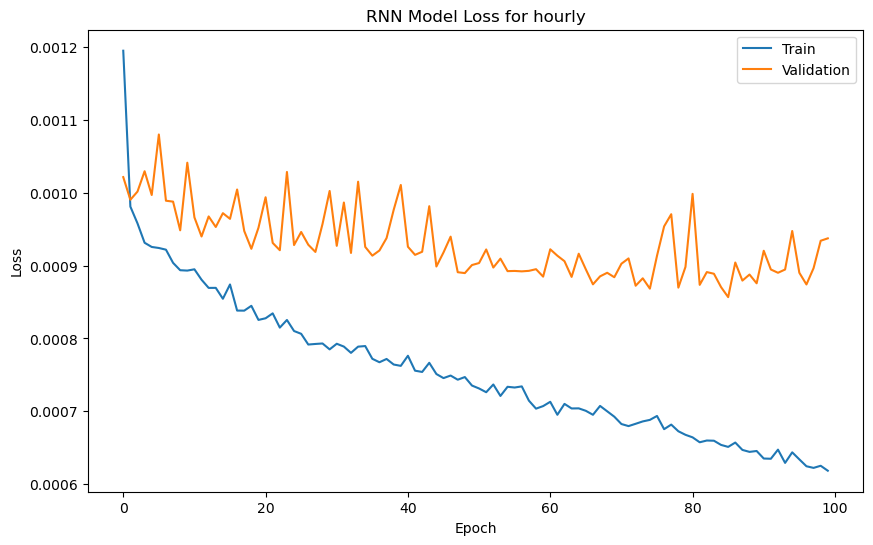

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Function to reshape data for RNN input
def reshape_rnn_input(data):
    return data.reshape((data.shape[0], 1, data.shape[1]))

# Function to train and evaluate RNN model
def train_and_evaluate_rnn(X_train, X_test, y_train, y_test):
    # Reshape data for RNN input
    X_train_rnn = reshape_rnn_input(X_train)
    X_test_rnn = reshape_rnn_input(X_test)

    # Build RNN model
    model = Sequential()
    model.add(LSTM(192, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(8, activation='linear'))
    model.add(Dense(4, activation='linear'))
    model.add(Dense(1, activation='linear'))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train model
    history = model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2)

    # Predict gas consumption on the test set
    predictions = model.predict(X_test_rnn).flatten()

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)

    return history, predictions, mae, mse, r2, mape

# Load and prepare data for different time periods
datasets = {
    "hourly": pd.read_csv('hourly_stat.csv').dropna(),
    "4 hourly": pd.read_csv('hourly_4_stat.csv').dropna(),
    "8 hourly": pd.read_csv('hourly_8_stat.csv').dropna(),
    "12 hourly": pd.read_csv('hourly_12_stat.csv').dropna(),
    "daily": pd.read_csv('daily_stat.csv').dropna(),
    "3 daily": pd.read_csv('3_daily_stat.csv').dropna()
}

# Initialize metrics dictionary
metrics = {
    "Model": [],
    "MAE": [],
    "MSE": [],
    "R²": [],
    "MAPE": []
}

# Train and evaluate RNN models for each dataset
for period, data in datasets.items():
    features = data[['SH_temp_mean', 'SH_hum_mean', 'DWH_temp_mean', 'DWH_hum_mean', 'ext_temp_mean', 'ext_hum_mean']].dropna()
    target = data['Gas_mean'].dropna()
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
    
    history, predictions, mae, mse, r2, mape = train_and_evaluate_rnn(X_train, X_test, y_train, y_test)
    
    metrics["Model"].append(f'RNN ({period})')
    metrics["MAE"].append(mae)
    metrics["MSE"].append(mse)
    metrics["R²"].append(r2)
    metrics["MAPE"].append(mape)

    # Plot training loss curve for each RNN model
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'RNN Model Loss for {period}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Plot actual vs predicted gas consumption over time
    date_test = data['date'].iloc[X_test.index]
    plt.figure(figsize=(14, 7))
    plt.plot(date_test, y_test, label='Actual Gas Consumption', marker='o')
    plt.plot(date_test, predictions, label='Predicted Gas Consumption', marker='x', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Gas Consumption')
    plt.title(f'Actual vs Predicted Gas Consumption for {period}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame(metrics)

# Plotting the evaluation metrics for comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('RNN Model Evaluation Metrics Comparison')

# Plot MAE
axes[0, 0].bar(metrics_df['Model'], metrics_df['MAE'], color='blue')
axes[0, 0].set_title('Mean Absolute Error (MAE)')
axes[0, 0].set_ylabel('MAE')

# Plot MSE
axes[0, 1].bar(metrics_df['Model'], metrics_df['MSE'], color='green')
axes[0, 1].set_title('Mean Squared Error (MSE)')
axes[0, 1].set_ylabel('MSE')

# Plot R²
axes[1, 0].bar(metrics_df['Model'], metrics_df['R²'], color='red')
axes[1, 0].set_title('R-squared (R²)')
axes[1, 0].set_ylabel('R²')

# Plot MAPE
axes[1, 1].bar(metrics_df['Model'], metrics_df['MAPE'], color='purple')
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)')
axes[1, 1].set_ylabel('MAPE')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.xticks(rotation=45)
plt.show()
